In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("online_shoppers_intention.csv")
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Check for missing values


In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

# Check for unique values


In [4]:
categorical_columns = ['Month', 'VisitorType', 'Weekend', 'Revenue']

for column in categorical_columns:
    print(f"{column}: {data[column].value_counts()}")
    print("")

Month: Month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64

VisitorType: VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64

Weekend: Weekend
False    9462
True     2868
Name: count, dtype: int64

Revenue: Revenue
False    10422
True      1908
Name: count, dtype: int64



# Feature Engineering

## Apply ordinal encoding


In [5]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

categorical_columns = ['Month', 'VisitorType', 'Weekend', 'Revenue']
data_encoded = ordinal_encoder.fit_transform(data[categorical_columns])
X_encoded = pd.DataFrame(data_encoded, columns=categorical_columns)
X_encoded.head()

,Month,VisitorType,Weekend,Revenue
0,2.0,2.0,0.0,0.0
1,2.0,2.0,0.0,0.0
2,2.0,2.0,0.0,0.0
3,2.0,2.0,0.0,0.0
4,2.0,2.0,1.0,0.0


## Apply scaling

In [6]:
from sklearn.preprocessing import RobustScaler

numerical_columns = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
scaler = RobustScaler()

data_scaled = scaler.fit_transform(data[numerical_columns])
X_scaled = pd.DataFrame(data_scaled, columns=numerical_columns)
data_scaled_encoded = pd.concat([X_scaled, X_encoded], axis=1)
data_scaled_encoded.head()



,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,VisitorType,Weekend,Revenue
0,-0.25,-0.080424,0.0,0.0,-0.548387,-0.467912,11.710742,4.895621,0.0,0.0,2.0,2.0,0.0,0.0
1,-0.25,-0.080424,0.0,0.0,-0.516129,-0.417913,-0.185128,2.095621,0.0,0.0,2.0,2.0,0.0,0.0
2,-0.25,-0.080424,0.0,0.0,-0.548387,-0.467912,11.710742,4.895621,0.0,0.0,2.0,2.0,0.0,0.0
3,-0.25,-0.080424,0.0,0.0,-0.516129,-0.465829,2.788840,3.215621,0.0,0.0,2.0,2.0,0.0,0.0
4,-0.25,-0.080424,0.0,0.0,-0.258065,0.022315,1.004459,0.695621,0.0,0.0,2.0,2.0,1.0,0.0


# Feature Selection

## Embedded Methods


### Lasso l1 regularization


**The reason why only L1 is applied:** L1 regularization has shrinks some of the coefficients to zero, therefore indicating that a certain predictor or certain features will be multiplied by zero to estimate the target. Thus, it won’t be added to the final prediction of the target—this means that these features can be removed because they aren’t contributing to the final prediction.

**However on L2 and combined L1/L2:** doesn’t set the coefficient to zero, but only approaching zero—that’s why we use only L1 in feature selection.

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

X = data_scaled_encoded.drop('Revenue', axis=1)
y = data_scaled_encoded['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

Lasso(alpha=0.01)

In [9]:
coeff = lasso.coef_
coeff

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.40727322e-05,
        9.39942645e-03,  9.68531044e-03, -0.00000000e+00, -2.00571653e-02,
        9.20203585e-03, -0.00000000e+00,  7.81741553e-03, -7.47179641e-03,
        0.00000000e+00])

In [10]:
df_coeff = pd.DataFrame({"features":X.columns,"coeff":coeff})
df_coeff.sort_values("coeff")

,features,coeff
7,ExitRates,-0.020057
11,VisitorType,-0.007472
0,Administrative,0.000000
1,Administrative_Duration,0.000000
2,Informational,0.000000
6,BounceRates,-0.000000
9,SpecialDay,-0.000000
12,Weekend,0.000000
3,Informational_Duration,0.000044
10,Month,0.007817


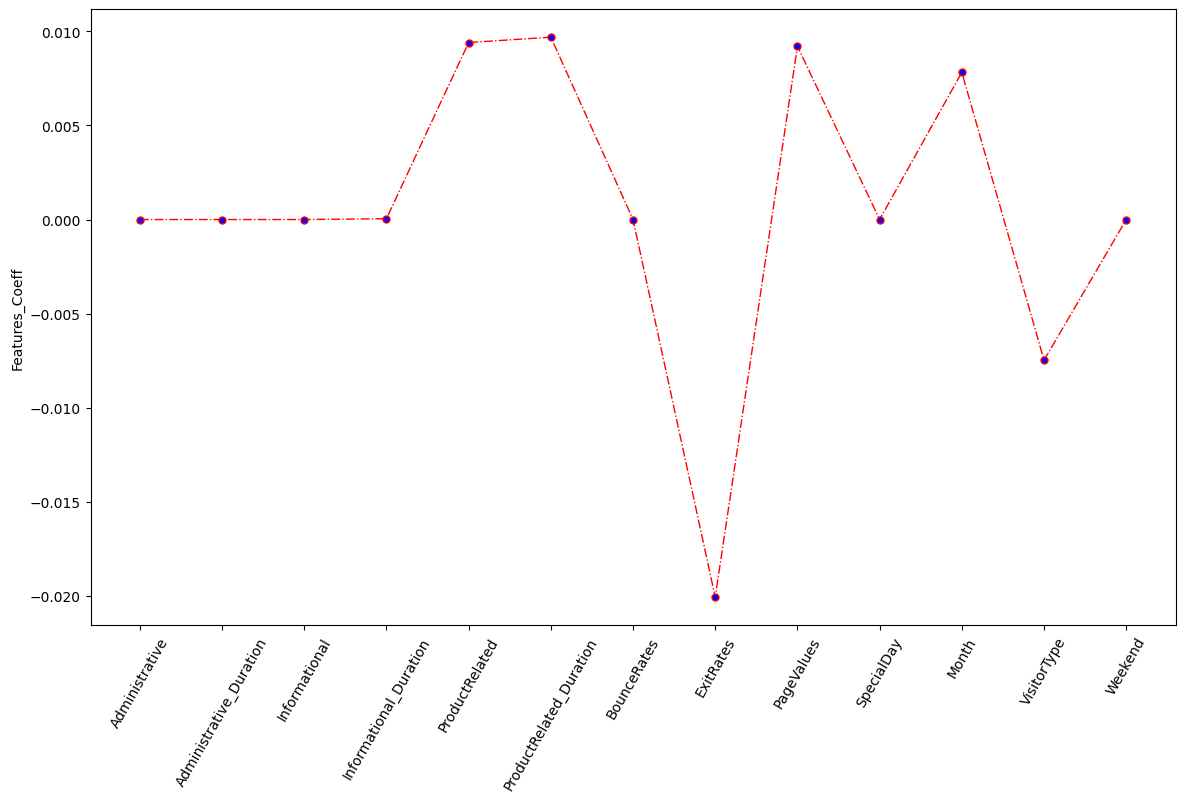

In [11]:
# Lets plot the coeff with features
plt.figure(figsize=(14,8))
plt.plot(range(len(X.columns)),coeff, color='red', linestyle='dashdot', linewidth = 1,marker='o', 
         markerfacecolor='blue', markersize=5)
plt.xticks(range(len(X.columns)),X.columns,rotation=60)
plt.ylabel("Features_Coeff")
plt.show()

<Axes: xlabel='features', ylabel='coeff'>

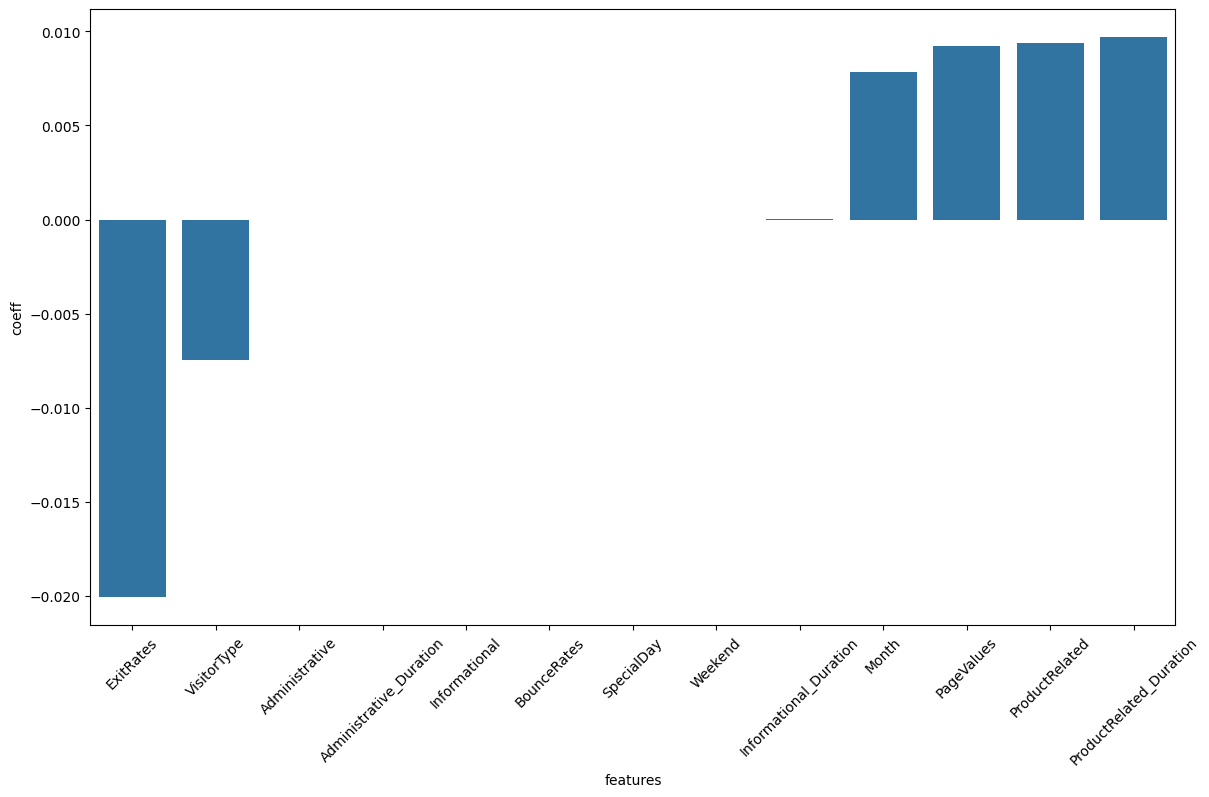

In [12]:
# Use Bar chart to show coeff
plt.figure(figsize=(14,8))
df_coeff.set_index('coeff')
# sort in ascending order to better visualization.
df_coeff = df_coeff.sort_values('coeff')
# plot the feature coeff in bars.
plt.xticks(rotation=45)
sns.barplot(x="features",y= "coeff", data=df_coeff)

In [13]:
selected_features = df_coeff[df_coeff['coeff'] != 0]['features'].tolist()
print(selected_features)

['ExitRates', 'VisitorType', 'Informational_Duration', 'Month', 'PageValues', 'ProductRelated', 'ProductRelated_Duration']


### Tree based Feature Selection


In [58]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
dtc = DecisionTreeClassifier(random_state=42)

rfc.fit(X_train, y_train)
etc.fit(X_train, y_train)
gbc.fit(X_train, y_train)
dtc.fit(X_train, y_train)

accuracy_rfc = accuracy_score(y_test, rfc.predict(X_test))
accuracy_etc = accuracy_score(y_test, etc.predict(X_test))
accuracy_gbc = accuracy_score(y_test, gbc.predict(X_test))
accuracy_dtc = accuracy_score(y_test, dtc.predict(X_test))

selector_rfc = SelectFromModel(rfc, prefit=True)
selector_rfc.fit(X_train, y_train)

selector_etc = SelectFromModel(etc, prefit=True)
selector_etc.fit(X_train, y_train)

selector_gbc = SelectFromModel(gbc, prefit=True)
selector_gbc.fit(X_train, y_train)

selector_dtc = SelectFromModel(dtc, prefit=True)
selector_dtc.fit(X_train, y_train)

selected_features_rfc = X_train.columns[selector_rfc.get_support()].tolist()
selected_features_etc = X_train.columns[selector_etc.get_support()].tolist()
selected_features_gbc = X_train.columns[selector_gbc.get_support()].tolist()
selected_features_dtc = X_train.columns[selector_dtc.get_support()].tolist()

[[0.000e+00 8.367e+03]
 [1.000e+00 1.497e+03]]
[0. 1.] [8367 1497]
[[0.000e+00 8.367e+03]
 [1.000e+00 8.367e+03]]


SelectFromModel(estimator=DecisionTreeClassifier(random_state=42), prefit=True)

In [60]:
models = ['Random Forest', 'Extra Trees', 'Gradient Boosting', 'Decision Tree']
accuracy_scores = [accuracy_rfc, accuracy_etc, accuracy_gbc, accuracy_dtc]

print("Selected Features:")
for model, features in zip(models, [selected_features_rfc, selected_features_etc, selected_features_gbc, selected_features_dtc]):
    print(f"{model}: {features}")

pd.DataFrame({'Model': models, 'Accuracy': accuracy_scores, 'Selected Features': [selected_features_rfc, selected_features_etc, selected_features_gbc, selected_features_dtc]})

Selected Features:
Random Forest: ['Administrative', 'ProductRelated_Duration', 'ExitRates', 'PageValues', 'Month']
Extra Trees: ['ExitRates', 'PageValues', 'Month']
Gradient Boosting: ['Administrative', 'PageValues', 'Month']
Decision Tree: ['Administrative', 'PageValues', 'Month']
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      2055
         1.0       0.64      0.72      0.68       411

    accuracy                           0.89      2466
   macro avg       0.79      0.82      0.80      2466
weighted avg       0.89      0.89      0.89      2466

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      2055
         1.0       0.65      0.65      0.65       411

    accuracy                           0.88      2466
   macro avg       0.79      0.79      0.79      2466
weighted avg       0.88      0.88      0.88      2466

              precision    recall  f1-score   support

       

,Model,Accuracy,Selected Features
0,Random Forest,0.675862,"[Administrative, ProductRelated_Duration, Exit..."
1,Extra Trees,0.652121,"[ExitRates, PageValues, Month]"
2,Gradient Boosting,0.688562,"[Administrative, PageValues, Month]"
3,Decision Tree,0.569507,"[Administrative, PageValues, Month]"


## Wrapper Methods


In [57]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

# Use RFECV instead of RFE for automatic selection of the optimal number of features
estimator = SVC(kernel='linear')
rfecv = RFECV(estimator, step=5, cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)
rfecv.fit(X_train, y_train)

# Get the selected features and their ranks
selected_features = X_train.columns[rfecv.support_]
feature_ranks = rfecv.ranking_

# Transform the train and test sets using the selected features
sel_X_train = rfecv.transform(X_train)
sel_X_test = rfecv.transform(X_test)

# Fit the estimator on the selected features and make predictions
estimator.fit(sel_X_train, y_train)
rfecv_preds = estimator.predict(sel_X_test)

# Calculate the F1 score
f1_score_rfecv = f1_score(y_test, rfecv_preds)

print("Selected Features:", selected_features)
print("Feature Ranks:", feature_ranks)
print("F1 Score:", f1_score_rfecv)

Selected Features: Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'VisitorType', 'Weekend'],
      dtype='object')
Feature Ranks: [1 1 1 1 1 1 1 1 1 1 1 1 1]
F1 Score: 0.4846526655896608
